In [2]:
import datetime
import calendar

from pycds import *
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import and_, or_
from sqlalchemy.sql import func

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgpasslib

In [4]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind = engine)
session = Session()

In [18]:
year = 2000 
month = 2
day = 15
interval = 1
yr_interval = 10

start_year = datetime.datetime(year, month, day)
end_year = datetime.datetime(year + yr_interval, month, day)

start_time = datetime.datetime(year, month, day)
end_time = datetime.datetime(year, month + interval, day)

In [19]:
def baseline(start_time, end_time):
    query = session.query(Obs.datum, Obs.time, Variable.standard_name, History.station_id).filter(Obs.time <= end_time).filter(Obs.time >= start_time).join(History).join(Variable)
    return query

def precip_query(start_time, end_time):
    query = baseline(start_time, end_time).filter(Variable.standard_name == "lwe_thickness_of_precipitation_amount").filter(or_(Variable.description == "Total precipiation", Variable.id == 1397))
    return query

def annual_rain(start_year, end_year):
    query = session.query(func.sum(Obs.datum).label("sum"), func.max(Obs.time).label("time"), History.lat, History.lon, History.station_id).group_by(History).filter(Variable.standard_name == "lwe_thickness_of_precipitation_amount").filter(or_(Variable.description == "Total precipiation", Variable.id == 1397))
    query = query.filter(Obs.time <= end_year).filter(Obs.time >= start_year).join(History).join(Variable)
    return query

In [20]:
q = annual_rain(start_year, end_year)

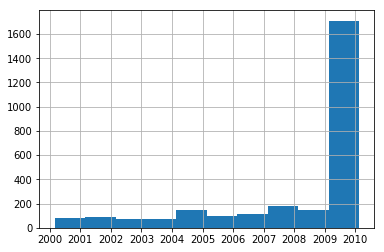

In [21]:
df = pd.read_sql(q.statement, engine)
df['time'].hist()

In [22]:
df

,sum,time,lat,lon,station_id
0,65745.0,2008-07-10,48.5733,-123.3920,16
1,127964.0,2010-02-15,48.9350,-123.7420,18
2,4903.0,2001-01-31,48.4178,-123.4810,22
3,7548.0,2001-03-11,48.7111,-123.5570,27
4,214265.0,2010-02-15,48.8244,-124.1330,29
5,187423.0,2010-02-15,48.8294,-124.0520,32
6,0.0,2005-08-31,48.4246,-123.2260,34
7,131498.0,2010-02-15,48.7347,-123.7280,39
8,55740.0,2010-02-15,48.4320,-123.4390,45
9,94411.0,2010-02-15,48.8717,-123.4980,48
